In [1]:
import warnings
warnings.filterwarnings("ignore")

#加载项目所需要的包
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import xgboost as xgb
from sklearn import preprocessing
from scipy import stats

In [2]:
#设置显示每列里的所有内容，而不会被默认砍掉
pd.set_option('display.max_colwidth', -1)

## 导入并初步了解数据集

In [3]:
#读入数据集，并查看数据集信息
df = pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 62.1+ MB


In [4]:
#只选取前400家店作为研究数据集
df = df[df['Store']<=400]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365208 entries, 0 to 1016494
Data columns (total 9 columns):
Store            365208 non-null int64
DayOfWeek        365208 non-null int64
Date             365208 non-null object
Sales            365208 non-null int64
Customers        365208 non-null int64
Open             365208 non-null int64
Promo            365208 non-null int64
StateHoliday     365208 non-null object
SchoolHoliday    365208 non-null int64
dtypes: int64(7), object(2)
memory usage: 25.1+ MB


In [5]:
#将时间列的数据类型转换成时间类型，并查看时间段
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].min(),df['Date'].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2015-07-31 00:00:00'))

In [6]:
#读入store数据集，并查看信息，有无缺失值等
df_store = pd.read_csv("store.csv")
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 74.1+ KB


In [7]:
#只节选数据集中前400家店
df_store = df_store[df_store['Store']<=400]
df_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Data columns (total 10 columns):
Store                        400 non-null int64
StoreType                    400 non-null object
Assortment                   400 non-null object
CompetitionDistance          399 non-null float64
CompetitionOpenSinceMonth    273 non-null float64
CompetitionOpenSinceYear     273 non-null float64
Promo2                       400 non-null int64
Promo2SinceWeek              206 non-null float64
Promo2SinceYear              206 non-null float64
PromoInterval                206 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 29.7+ KB


In [8]:
#查看节选后的数据集的首尾情况
df_store.head().append(df_store.tail()) 

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
395,396,a,c,23130.0,NaN,NaN,0,NaN,NaN,NaN
396,397,a,c,130.0,NaN,NaN,1,27.0,2013.0,"Feb,May,Aug,Nov"
397,398,c,c,1540.0,NaN,NaN,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
398,399,a,a,5360.0,9.0,2012.0,1,40.0,2011.0,"Jan,Apr,Jul,Oct"
399,400,a,a,70.0,11.0,2004.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


In [9]:
#查看store数据集中店的类型和出现频次
df_store['StoreType'].value_counts()

a    220
d    133
c    41 
b    6  
Name: StoreType, dtype: int64

In [10]:
#查看store数据集中店的分类和出现频次
df_store['Assortment'].value_counts()

a    217
c    180
b    3  
Name: Assortment, dtype: int64

Type b的类型和Type b的assortment分类的店的数量比较少，都是个位数。

In [11]:
#读入测试数据集
df_test = pd.read_csv("test.csv")

In [12]:
#截取前400家店进行预测，并查看信息
df_test = df_test[df_test['Store']<=400]
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14736 entries, 0 to 40538
Data columns (total 8 columns):
Id               14736 non-null int64
Store            14736 non-null int64
DayOfWeek        14736 non-null int64
Date             14736 non-null object
Open             14736 non-null float64
Promo            14736 non-null int64
StateHoliday     14736 non-null object
SchoolHoliday    14736 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 921.0+ KB


In [13]:
#将时间列的数据类型转换成时间型，并查看时间段
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test['Date'].min(),df_test['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

由上，需预测的测试集为2015年8月1日-2015年9月17日的六周的营业额。

## 数据预处理&探索性数据分析EDA

In [14]:
#对时间进行转换，形成新的特征
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['WeekOfYear'] = df['Date'].dt.weekofyear
df['DayOfYear']=df['Date'].dt.dayofyear

In [15]:
#查看是否有商店开门，但顾客和销售额为零的情况
df[(df['Sales']==0)&(df['Open']==1)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,DayOfYear
330176,357,1,2014-09-22,0,0,1,0,0,0,2014,9,22,39,265
340348,227,4,2014-09-11,0,0,1,0,0,0,2014,9,11,37,254
346734,28,4,2014-09-04,0,0,1,1,0,0,2014,9,4,36,247
347669,28,3,2014-09-03,0,0,1,1,0,1,2014,9,3,36,246
348604,28,2,2014-09-02,0,0,1,1,0,1,2014,9,2,36,245
386065,102,4,2014-07-24,0,0,1,0,0,1,2014,7,24,30,205
386173,238,4,2014-07-24,0,0,1,0,0,1,2014,7,24,30,205
386227,303,4,2014-07-24,0,0,1,0,0,1,2014,7,24,30,205
386304,387,4,2014-07-24,0,0,1,0,0,1,2014,7,24,30,205
397285,102,6,2014-07-12,0,0,1,0,0,0,2014,7,12,28,193


以上店开门，但是顾客和销售额为零的情况，被认为是数据记录有误，因此以下进行删除。

In [16]:
#删除顾客为零的情况
df = df[df['Customers']!=0]
#并查看
df[df['Customers']==0]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,DayOfYear


In [17]:
#查看商店关门的情况，是否已经删除
df[df['Open']==0]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,DayOfYear


In [18]:
#查看销售额为零的情况，是否已经删除
df[df['Sales']==0]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,DayOfYear


In [19]:
#查看Sales列的统计情况
df['Sales'].describe()

count    303023.000000
mean     6935.759744  
std      3010.540735  
min      297.000000   
25%      4926.000000  
50%      6394.000000  
75%      8280.000000  
max      38722.000000 
Name: Sales, dtype: float64

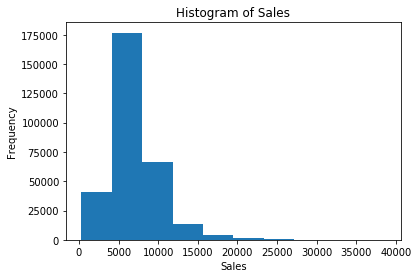

In [20]:
#对Sales列做直方图，查看其分布
plt.rcParams["figure.figsize"] = [6,4]
df['Sales'].plot(kind='hist')
plt.title('Histogram of Sales')
plt.xlabel('Sales')
plt.show()

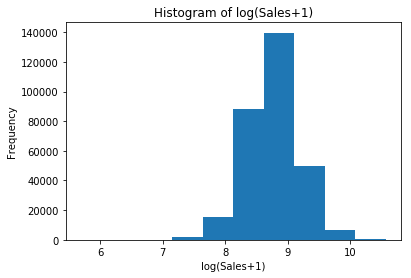

In [21]:
#因为Sales分布有明显的右偏情况，因此取对数，再次查看分布情况
log_sales = np.log(df['Sales']+1)
log_sales.plot(kind='hist')
plt.rcParams["figure.figsize"] = [6,4]
plt.title('Histogram of log(Sales+1)')
plt.xlabel('log(Sales+1)')
plt.show()

In [22]:
#增加新的特征列
df['SalesPerCustomer'] = df['Sales']/df['Customers']
df['SalesPerCustomer'].describe()

count    303023.000000
mean     9.619229     
std      2.138058     
min      2.752415     
25%      8.055799     
50%      9.376652     
75%      10.986340    
max      57.614983    
Name: SalesPerCustomer, dtype: float64

In [23]:
#查看是否还有缺失值
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303023 entries, 0 to 1016447
Data columns (total 15 columns):
Store               303023 non-null int64
DayOfWeek           303023 non-null int64
Date                303023 non-null datetime64[ns]
Sales               303023 non-null int64
Customers           303023 non-null int64
Open                303023 non-null int64
Promo               303023 non-null int64
StateHoliday        303023 non-null object
SchoolHoliday       303023 non-null int64
Year                303023 non-null int64
Month               303023 non-null int64
Day                 303023 non-null int64
WeekOfYear          303023 non-null int64
DayOfYear           303023 non-null int64
SalesPerCustomer    303023 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(12), object(1)
memory usage: 35.8+ MB


以上训练数据集没有缺失值了。现在对store数据集进行缺失值处理。

In [24]:
#查看商店数据集的信息
df_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Data columns (total 10 columns):
Store                        400 non-null int64
StoreType                    400 non-null object
Assortment                   400 non-null object
CompetitionDistance          399 non-null float64
CompetitionOpenSinceMonth    273 non-null float64
CompetitionOpenSinceYear     273 non-null float64
Promo2                       400 non-null int64
Promo2SinceWeek              206 non-null float64
Promo2SinceYear              206 non-null float64
PromoInterval                206 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 29.7+ KB


In [25]:
#CompetitionDistance列中唯一一个缺失值，由中值来填充
df_store['CompetitionDistance'].fillna(df_store['CompetitionDistance'].median(), inplace = True)

In [26]:
#store数据集中其它的缺失值，都由0来填充
df_store.fillna(0, inplace = True)

In [27]:
#根据大家的讨论，这一列特征对预测没有太多帮助，故删除
df_store.drop('PromoInterval', axis=1, inplace = True)

In [28]:
#再次查看数据集
df_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Data columns (total 9 columns):
Store                        400 non-null int64
StoreType                    400 non-null object
Assortment                   400 non-null object
CompetitionDistance          400 non-null float64
CompetitionOpenSinceMonth    400 non-null float64
CompetitionOpenSinceYear     400 non-null float64
Promo2                       400 non-null int64
Promo2SinceWeek              400 non-null float64
Promo2SinceYear              400 non-null float64
dtypes: float64(5), int64(2), object(2)
memory usage: 28.1+ KB


Store数据集也没有缺失值了。以下开始数据集的合并和预处理。

In [29]:
#将分别预处理过的train和store两个数据集进行合并
df_train = pd.merge(df, df_store, how = 'inner', on = 'Store')
df_train.drop('StateHoliday',axis=1,inplace=True)

In [30]:
# competition open持续的时间（以月计）
df_train['CompetitionOpen'] = 12 * (df_train.Year - df_train.CompetitionOpenSinceYear) + (df_train.Month - df_train.CompetitionOpenSinceMonth)
    
# Promo持续的时间 (以月计，假设每个月均为四周）
df_train['PromoOpen'] = 12 * (df_train.Year - df_train.Promo2SinceYear) + (df_train.WeekOfYear - df_train.Promo2SinceWeek)/4.0 

In [31]:
#以下以同样的方式，对test数据集进行预处理
df_test['Year'] = df_test['Date'].dt.year
df_test['Month'] = df_test['Date'].dt.month
df_test['Day'] = df_test['Date'].dt.day
df_test['WeekOfYear'] = df_test['Date'].dt.weekofyear
df_test['DayOfYear']=df_test['Date'].dt.dayofyear

In [32]:
#将test数据集和store数据集进行合并
df_test = pd.merge(df_test, df_store, how = 'inner', on = 'Store')
df_test.drop('StateHoliday', axis=1, inplace=True)
df_test['CompetitionOpen'] = 12 * (df_test.Year - df_test.CompetitionOpenSinceYear) + (df_test.Month - df_test.CompetitionOpenSinceMonth)
df_test['PromoOpen'] = 12 * (df_test.Year - df_test.Promo2SinceYear) + (df_test.WeekOfYear - df_test.Promo2SinceWeek) / 4.0

### 可视化&EDA

Text(0.5,1,'Store 1')

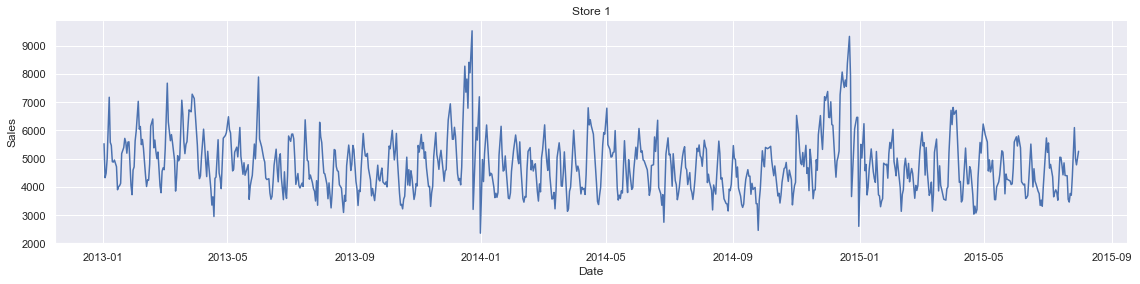

In [33]:
#随机查看五家店的日营业额（Store 1,100,200,300,400）
store_1 = df_train.loc[df_train.Store==1]
sns.set()
sns.relplot(x='Date', y='Sales', kind='line',data=store_1, height=4, aspect=4.)
plt.title('Store 1')

Text(0.5,1,'Store 100')

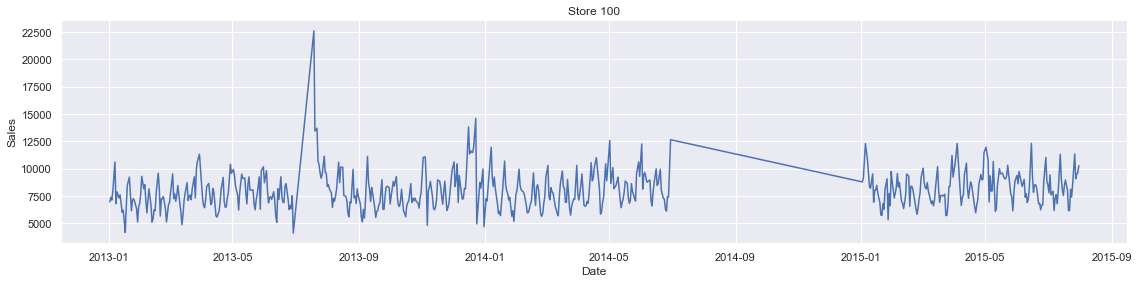

In [34]:
store_100 = df_train.loc[df_train.Store==100]
sns.relplot(x='Date', y='Sales', kind='line',data=store_100, height=4, aspect=4.)
plt.title('Store 100')

In [35]:
#查看store_100中的缺失值
store_100[store_100['Sales']==0]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,Year,Month,...,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,CompetitionOpen,PromoOpen


store 100中没有销售额为零的情况。中间有两次长期关店的情况，应该是在重新装修。还有一个较高的零售额较高。如若是outliers，则在下面会进行删除处理。

Text(0.5,1,'Store 200')

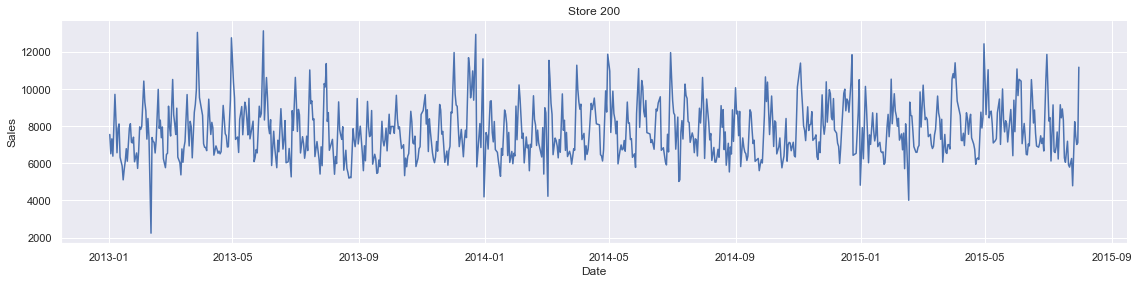

In [36]:
store_200 = df_train.loc[df_train.Store==200]
sns.relplot(x='Date', y='Sales', kind='line',data=store_200, height=4, aspect=4.)
plt.title('Store 200')

Text(0.5,1,'Store 300')

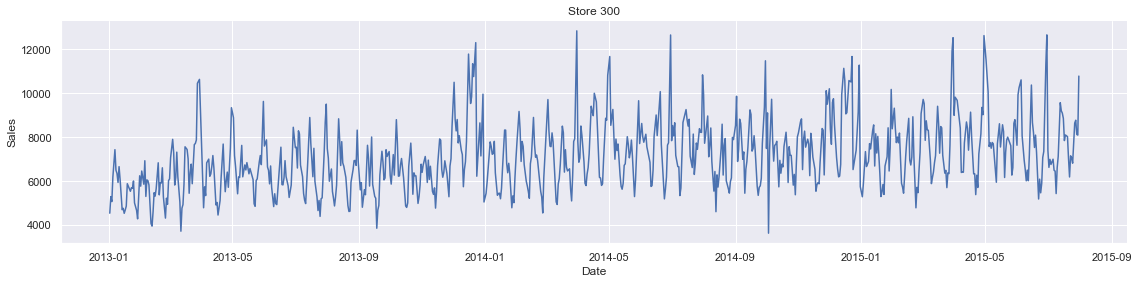

In [37]:
store_300 = df_train.loc[df_train.Store==300]
sns.relplot(x='Date', y='Sales', kind='line',data=store_300, height=4, aspect=4.)
plt.title('Store 300')

Text(0.5,1,'Store 400')

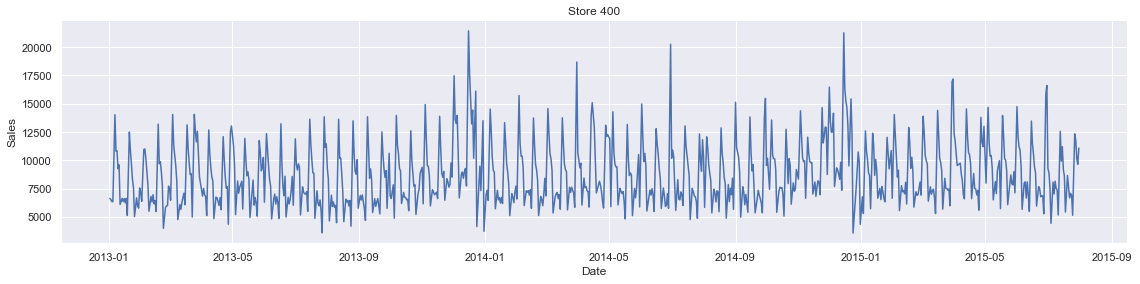

In [38]:
store_400 = df_train.loc[df_train.Store==400]
sns.relplot(x='Date', y='Sales', kind='line',data=store_400, height=4, aspect=4.)
plt.title('Store 400')

以上5家店这31个月中的日营业额没有明显的增加或减少的趋势。季节性的趋势也不明显，除了每年12月底的圣诞季有明显的营业额增加的情况。

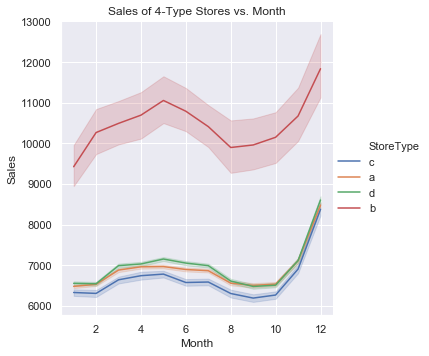

In [39]:
#查看不同种类的店的总营业额(按月计)
sns.relplot(data = df_train, x = 'Month', y = "Sales", kind='line', hue = 'StoreType')
plt.title('Sales of 4-Type Stores vs. Month')
plt.show()

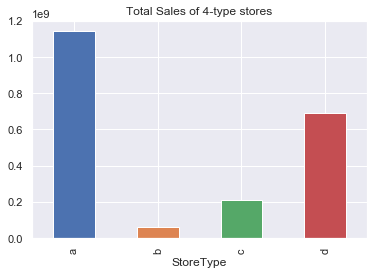

In [40]:
#查看四种类型的店的总营业额
df_train.groupby(['StoreType'])['Sales'].sum().plot(kind='bar')
plt.title('Total Sales of 4-type stores')
plt.show()

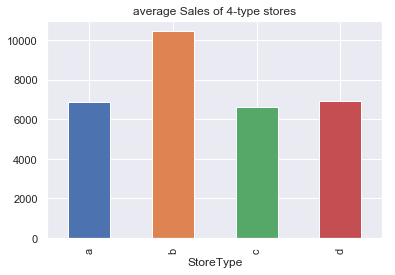

In [41]:
#查看四种类型的店的平均营业额
df_train.groupby(['StoreType'])['Sales'].mean().plot(kind='bar')
plt.title('average Sales of 4-type stores')
plt.show()

以上为四种类型的店的营业额，从1-12月的变化趋势。四种类型的店的变化趋势类似，都是从1月到5月稳步增长，然后在5-8月区间，略有下降。从8月-12月，四种店的营业总额呈现非常明显的增长趋势。在圣诞节的假期季，总的销售额达到全年最高峰。

Type b的店的总营业额远远大于另外三种的店（Type a,c,d）的营业额。其它三种类型的店的总营业额很接近。Type b的总营业额远远大于另外三种店，应该跟该种店的数量多有关系。以上四种类型的商店的营业额平均值比较接近，从而证实了这个猜测。

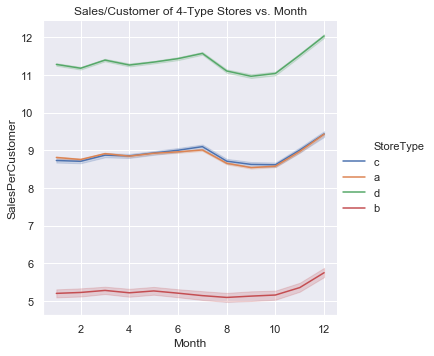

In [42]:
#查看全年1-12月中，四种类型的店中单位顾客数的销售额
sns.relplot(data = df_train, x = 'Month', y = "SalesPerCustomer", kind='line', hue = 'StoreType')
plt.title('Sales/Customer of 4-Type Stores vs. Month')
plt.show()

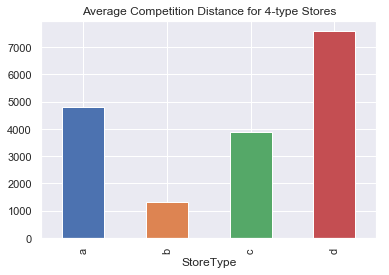

In [43]:
df_train.groupby(['StoreType'])['CompetitionDistance'].mean().plot(kind='bar')
plt.title('Average Competition Distance for 4-type Stores')
plt.show()

每年1-12月，四种类型的店中，单位客人的零售额呈现非常明显的分化趋势：Type d基本是Type b的两倍，而Type a和Type c基本持平。从竞争者的距离来看，Type d的平均距离远大于Type b，Type a和Type c的平均距离比较接近。远离了竞争者，这可能是能促进销售的很重要的一点。这点在下面的paired correlation matrix也得到了验证。

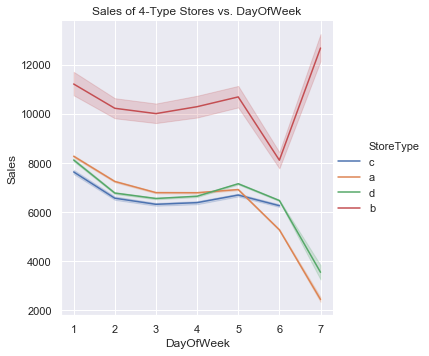

In [44]:
#查看每周7天，四种类型的店的零售额
sns.relplot(data = df_train, x = 'DayOfWeek', y = "Sales", kind='line', hue = 'StoreType')
plt.title('Sales of 4-Type Stores vs. DayOfWeek')
plt.show()

Type c店周日是不营业的。a和d在周末的销售额急剧下降，而b在周六零售额下降，却在周日急剧上升。同时，大众会倾向于在每周的前五天内购物，尤其是周一的零售额的增加非常明显。

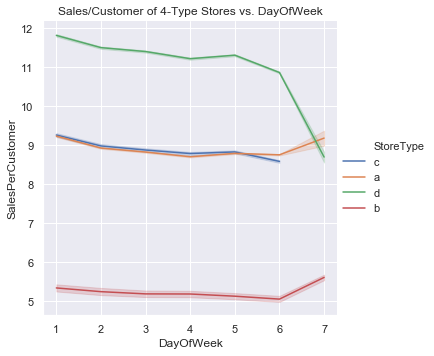

In [45]:
sns.relplot(data = df_train, x = 'DayOfWeek', y = "SalesPerCustomer", kind='line', hue = 'StoreType')
plt.title('Sales/Customer of 4-Type Stores vs. DayOfWeek')
plt.show()

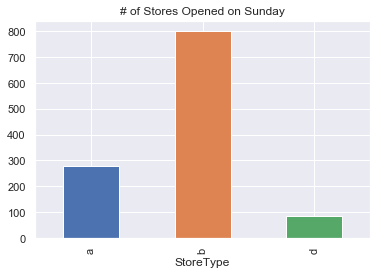

In [46]:
df_train[(df_train['DayOfWeek']==7)& (df_train['Open']==1)].groupby(['StoreType'])['Open'].sum().plot(kind='bar')
plt.title('# of Stores Opened on Sunday')
plt.show()

正因为在周日这天，营业的b型店的数目很大，导致它的营业额在周日也急剧增长。同样地，由于d型远离竞争者，所以在7天内，它的单位顾客的零售额远高于其它三种店。

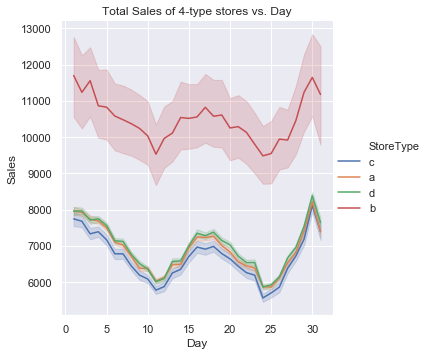

In [47]:
#月内销售额的趋势
sns.relplot(data = df_train, kind='line',x = 'Day', y = "Sales", hue = 'StoreType')
plt.title('Total Sales of 4-type stores vs. Day')
plt.show()

四种店在月内，呈现相同的趋势。大家在月初和月末的购买的量比较大。而且很明显的，在每个月12日和24日左右，有两个零售额的低点。月内的这种低点和月初月末的高点，应该和德国两周发一次工资的周期是相关联的。

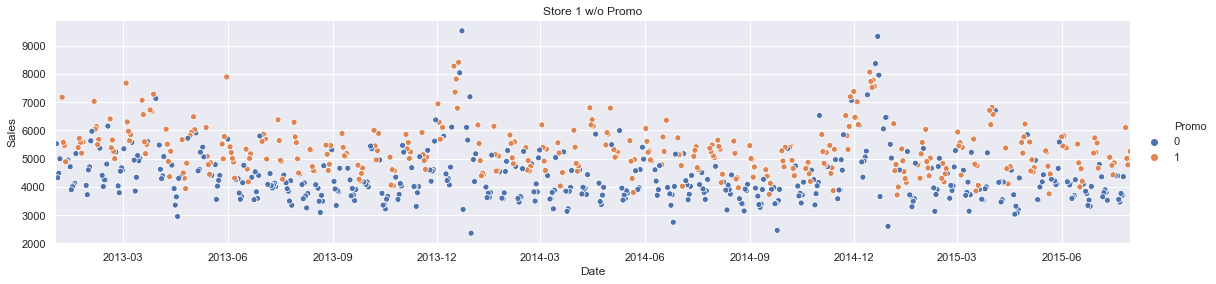

In [48]:
#查看Promo对单店的影响
sns.relplot(x='Date', y='Sales', data=store_1, hue="Promo",height=4, aspect = 4.)
plt.xlim('2013-01-01','2015-07-31')
plt.title('Store 1 w/o Promo')
plt.show()

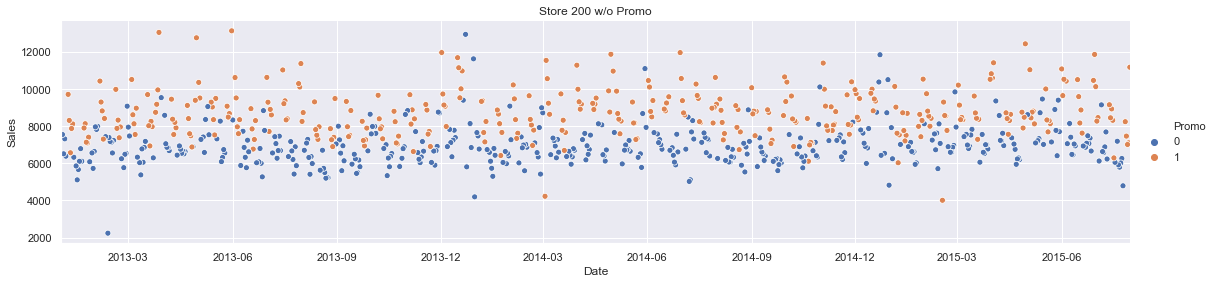

In [49]:
sns.relplot(x='Date', y='Sales', data=store_200, hue="Promo",height=4, aspect = 4.)
plt.xlim('2013-01-01','2015-07-31')
plt.title('Store 200 w/o Promo')
plt.show()

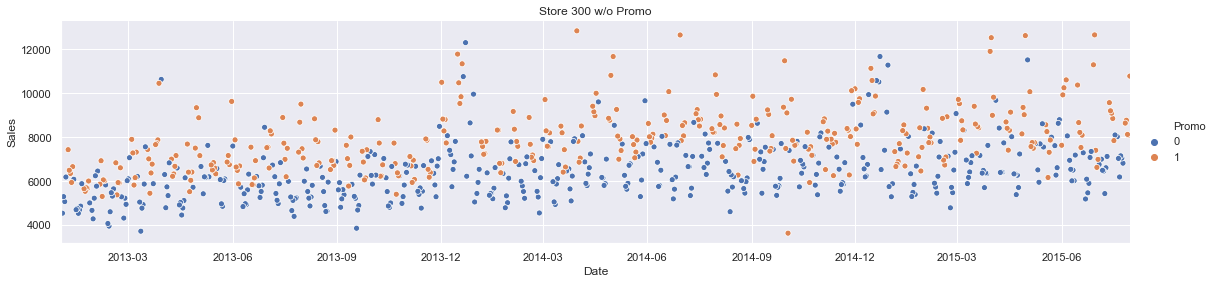

In [50]:
sns.relplot(x='Date', y='Sales',data=store_300, hue="Promo",height=4, aspect = 4.)
plt.xlim('2013-01-01','2015-07-31')
plt.title('Store 300 w/o Promo')
plt.show()

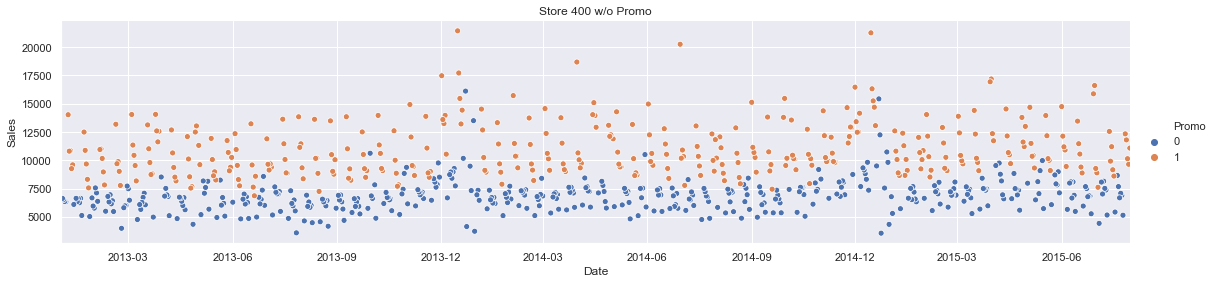

In [51]:
sns.relplot(x='Date', y='Sales', data=store_400, hue="Promo",height=4, aspect = 4.)
plt.xlim('2013-01-01','2015-07-31')
plt.title('Store 400 w/o Promo')
plt.show()

从以上可以看出，Promo的促销明显能提升销售额。但是下方Promo2的持续性促销，则并没有提升零售额的效果。

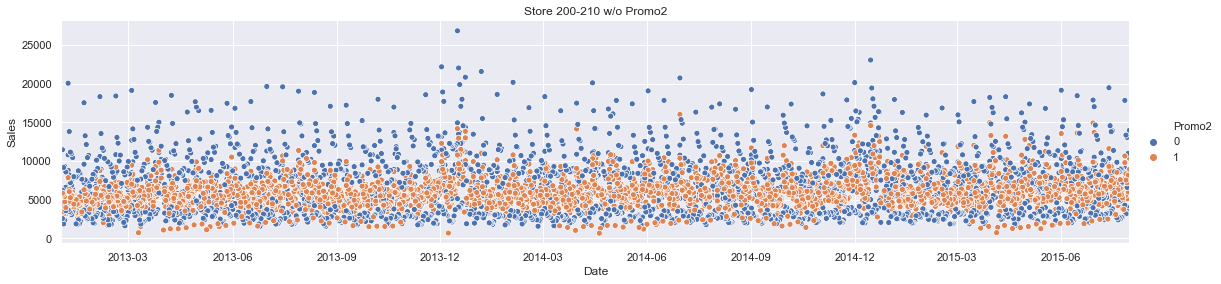

In [52]:
#查看Promo2对零售额的影响
sns.relplot(x='Date', y='Sales',data=df_train[(df_train['Store']>200)&(df_train['Store']<210)], hue="Promo2",height=4, aspect = 4.)
plt.xlim('2013-01-01','2015-07-31')
plt.title('Store 200-210 w/o Promo2')
plt.show()

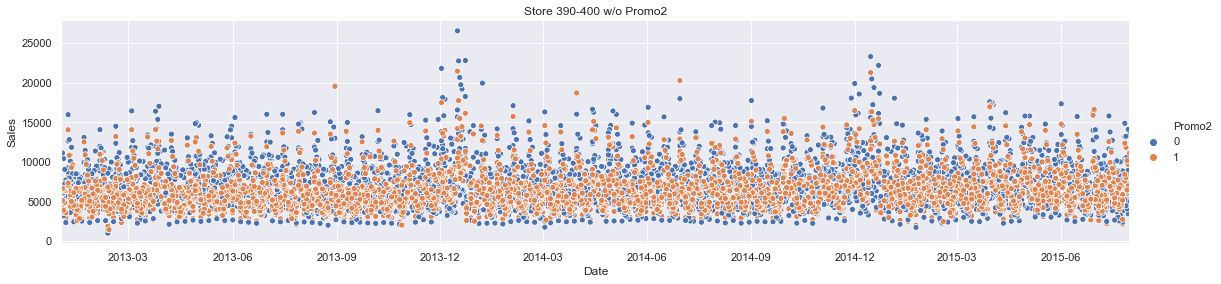

In [53]:
#查看Promo2对零售额的影响
sns.relplot(x='Date', y='Sales',data=df_train[df_train['Store']>390], hue="Promo2",height=4, aspect = 4.)
plt.xlim('2013-01-01','2015-07-31')
plt.title('Store 390-400 w/o Promo2')
plt.show()

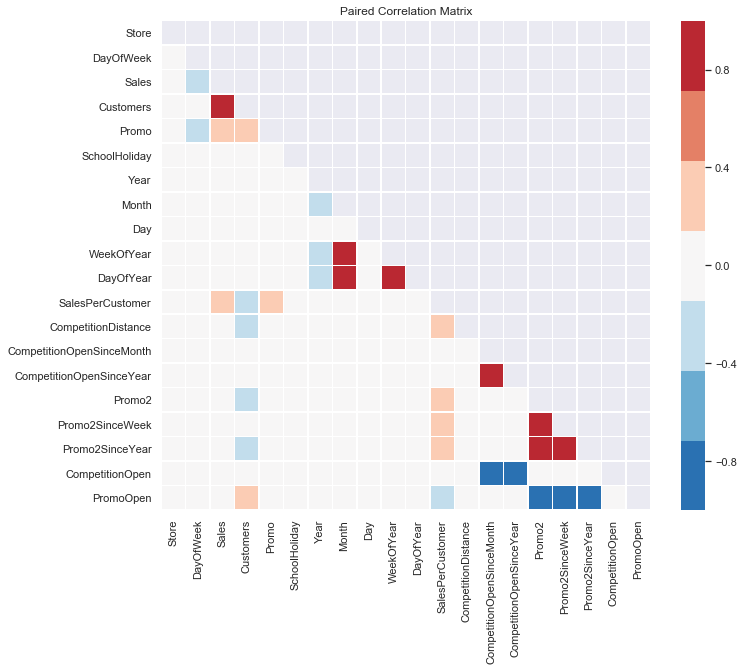

In [54]:
# 查看特征之间配对correlation matrix 
# 由于Open列均为1，所以跟其它列没有关联，故删除
corr_all = df_train.drop('Open',axis=1).corr()

mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (11, 9))

cmap = sns.color_palette("RdBu_r", 7)
sns.heatmap(corr_all, mask = mask, square = True, linewidths = .5,cmap=cmap)
plt.title('Paired Correlation Matrix')
plt.show()

由以上配对的correlation matrix可以看出，

有正相关性的配对特征有(相关系数在0 - 0.4之间，比较弱)：
- Promo - Sales：  促销能促进销售额
- Promo - Customers：  促销能增加顾客
- Promo2 - SalesPerCustomer：  持续的季节性的促销，能促进单位顾客的购买量
- PromoOpen - Customers：  促销的时间越长，能带来的顾客越多
- CompetitionDistance - SalesPerCustomer：  竞争对手的距离越远，单位顾客的购买量越多

有负相关性的配对特征有(相关系数在- 0.4 - 0之间，比较弱)：
- CompetitionDistance - Customers：  竞争对手的距离越远，带来顾客数越少（这点比较意外）
- Sales - DayofWeek：  大家倾向于在每周前几日购物，而不是周末（这个也许跟周末关门或促销有关系）
- Promo - DayofWeek：  促销通常在每周的前几日进行
- Promo2 - Customers：  持续的季节性促销，反正不能显著带来顾客

## 训练模型

以下对分类变量列进行编码预处理，因为DMatrix的载入，只认int,float和bool型。

In [55]:
# 对train和test sets分类变量进行编码预处理
dummies1 = pd.get_dummies(df_train['StoreType'],prefix ='st', drop_first=True)
dummies2 = pd.get_dummies(df_train['Assortment'],prefix ='As', drop_first=True)

dummies3 = pd.get_dummies(df_test['StoreType'],prefix ='st', drop_first=True)
dummies4 = pd.get_dummies(df_test['Assortment'],prefix ='As', drop_first=True)

df_train =  pd.concat([df_train, dummies1, dummies2], axis=1).drop(['StoreType','Assortment'],axis=1)
df_test =  pd.concat([df_test, dummies3, dummies4], axis=1).drop(['StoreType','Assortment'],axis=1)

由于我们要预测的是test数据集的营业额(从2015年8月1日-2015年9月17日），而营业额在kaggle上并没有公布，因此本项目就无法根据营业额的预测值和实际值来计算rmspe。为了通过rmspe来评估本模型，我需要提前从train数据集中切出一部分数据来，用于后续的模型评估。

因此，我提前切分出2018年7月1日到7月31日整个月的数据来。

In [56]:
#切分2015年7月的数据，作为模型评估的验证集
df_eval = df_train[(df_train['Year']==2015)&(df_train['Month']==7)]
df_eval.shape

(10822, 27)

In [57]:
#从训练集中删除2015年7月数据
df_train.drop(df_train[(df_train['Year']==2015)&(df_train['Month']==7)].index,inplace=True)
df_train.shape

(292201, 27)

由于rmspe对异常值比较敏感，而且之前跑的回归模型在没有删除异常值时，以下rmspe_7得分为0.165左右，不太理想。因此在此处删除异常值。

定义异常值的方法大致有三种（https://docs.oracle.com/cd/E40248_01/epm.1112/cb_statistical/frameset.htm?ch07s02s10s01.html）
此处我们采用第一种方法定义异常值：当营业额的标准偏差std三倍于营业额的平均值时（此处的阈值3为默认值），则该营业额被认为是异常值。

In [58]:
#从训练集和验证集处理缺失值
#https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-dataframe
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html
df_train = df_train[(np.abs(stats.zscore(df_train['Sales'])) < 2 )]
df_eval = df_eval[(np.abs(stats.zscore(df_eval['Sales'])) < 2 )]
df_train.shape, df_eval.shape

((280227, 27), (10394, 27))

**以上根据standard deviationda$\geq$2，来重新定义和识别outliers。从而删除掉现在无法得知test测试集中是否有outliers。之前当阈值设定为3时，训练集中有1.6% 的outliers被删除。现在当阈值设定为2时，训练集中有4%的outliers被删除。**

In [59]:
#DMatrix的载入，只认int,float和bool型,因此还需转换时间类型

df_train['Date'] = df_train['Date'].astype(np.int64) 
df_eval['Date'] = df_eval['Date'].astype(np.int64) 
df_test['Date'] = df_test['Date'].astype(np.int64) 

In [60]:
# 将训练集切分成特征和对应的标签
y = np.log(df_train['Sales']+1) # 对销售额作对数转换，+1是为了避免sales为零的情况
X = df_train.drop(['Sales'],axis = 1)

In [61]:
# 导入 train_test_split
from sklearn.model_selection import train_test_split

# 将'X_train'和'y_train'进一步切分为训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)

Kaggle上所有参赛者的提交结果都会统一计算rmspe值。计算方法如下：

$${RMSPE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{y_i - \hat{y}_i}{y_i}\right)^2}$$

其中， 代表了单店的单日营业额，  则代表了相应的预测营业额。当 =0，即单店单日营业额为零。在计算RMSPE的过程中，这种数据会被自然忽略。

In [62]:
#Kaggle论坛中大家通用的计算RMSPE函数代码
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [63]:
#训练集，评估集，测试集统一特征列
features = [x for x in df_train.columns if x not in ['Sales','Customers','SalesPerCustomer']]
features

['Store',
 'DayOfWeek',
 'Date',
 'Open',
 'Promo',
 'SchoolHoliday',
 'Year',
 'Month',
 'Day',
 'WeekOfYear',
 'DayOfYear',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'CompetitionOpen',
 'PromoOpen',
 'st_b',
 'st_c',
 'st_d',
 'As_b',
 'As_c']

以上为用于模型训练的所有的特征变量。

In [64]:
# 载入训练集和检验集到DMatrix
dtrain = xgb.DMatrix(X_train[features],y_train)
dval = xgb.DMatrix(X_val[features], y_val)

evallist = [(dtrain, 'train'), (dval, 'test')]

**当回归模型的误差rmspe不再下降时，回归模型被认为收敛，xgb自动终止。首先仍然使用原来的参赛者的参数,rmspe得分为0.132。**

In [65]:
# 起始模型参数采用了优胜参赛者提供的优化参数（https://www.kaggle.com/abhilashawasthi/xgb-rossmann ），
'''
params = { 'objective': "reg:linear", 
        'booster': "gbtree", 
        'eta' : 0.02,      
        'max_depth': 12,   
        'subsample': 0.9,  
        'colsample_bytree':0.7, 
        'seed': 0} 
num_round = 10000
xgb_2 = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds = 10, feval = rmspe_xg, verbose_eval = 200)
'''

'\nparams = { \'objective\': "reg:linear", \n        \'booster\': "gbtree", \n        \'eta\' : 0.02,      \n        \'max_depth\': 12,   \n        \'subsample\': 0.9,  \n        \'colsample_bytree\':0.7, \n        \'seed\': 0} \nnum_round = 10000\nxgb_2 = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds = 10, feval = rmspe_xg, verbose_eval = 200)\n'

**以下为前两版所用参数，拿到0.130的得分**

In [66]:
'''
params = { 'objective': "reg:linear", 
           'booster': "gbtree",
            'eta' : 0.01,    # learing rate，从0.02降到0.01，可以减少过拟合，但需同步增加num_round 
            'max_depth': 10,  # 树的深度从12降到10，可以有效减少过拟合，default = 6 
            'subsample': 0.8,  # 从0.9降到0.8，20%的几率随机生成树，这样可以避免过拟合,default =1
            'colsample_bytree':0.7, #也可以降低过拟合的情况，default = 1
            'seed': 0} 
num_round = 10000
xgb_2 = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds = 10, feval = rmspe_xg, verbose_eval = 200)
'''

'\nparams = { \'objective\': "reg:linear", \n           \'booster\': "gbtree",\n            \'eta\' : 0.01,    # learing rate，从0.02降到0.01，可以减少过拟合，但需同步增加num_round \n            \'max_depth\': 10,  # 树的深度从12降到10，可以有效减少过拟合，default = 6 \n            \'subsample\': 0.8,  # 从0.9降到0.8，20%的几率随机生成树，这样可以避免过拟合,default =1\n            \'colsample_bytree\':0.7, #也可以降低过拟合的情况，default = 1\n            \'seed\': 0} \nnum_round = 10000\nxgb_2 = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds = 10, feval = rmspe_xg, verbose_eval = 200)\n'

**进行参数微调，多种组合的参数，拿到的结果均为0.130**

In [67]:
'''
params = { 'objective': "reg:linear", 
           'booster': "gbtree",
            'eta' : 0.01,    # learing rate，从0.02降到0.01，可以减少过拟合，但需同步增加num_round 
            'max_depth': 10,  # 树的深度从12降到10，可以有效减少过拟合，default = 6 
            'subsample': 0.9,  # 从0.9降到0.8，20%的几率随机生成树，这样可以避免过拟合,default =1
            'colsample_bytree':0.7, #也可以降低过拟合的情况，default = 1
            'seed': 0} 
num_round = 10000
xgb_2 = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds = 10, feval = rmspe_xg, verbose_eval = 200)
'''

'\nparams = { \'objective\': "reg:linear", \n           \'booster\': "gbtree",\n            \'eta\' : 0.01,    # learing rate，从0.02降到0.01，可以减少过拟合，但需同步增加num_round \n            \'max_depth\': 10,  # 树的深度从12降到10，可以有效减少过拟合，default = 6 \n            \'subsample\': 0.9,  # 从0.9降到0.8，20%的几率随机生成树，这样可以避免过拟合,default =1\n            \'colsample_bytree\':0.7, #也可以降低过拟合的情况，default = 1\n            \'seed\': 0} \nnum_round = 10000\nxgb_2 = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds = 10, feval = rmspe_xg, verbose_eval = 200)\n'

In [68]:
'''
params = { 'objective': "reg:linear", 
           'booster': "gbtree",
            'eta' : 0.01,    # learing rate，从0.02降到0.01，可以减少过拟合，但需同步增加num_round 
            'max_depth': 12,  # 树的深度从12降到10，可以有效减少过拟合，default = 6 
            'subsample': 0.8,  # 从0.9降到0.8，20%的几率随机生成树，这样可以避免过拟合,default =1
            'colsample_bytree':0.7, #也可以降低过拟合的情况，default = 1
            'seed': 0} 
num_round = 10000
xgb_2 = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds = 10, feval = rmspe_xg, verbose_eval = 200)
'''

'\nparams = { \'objective\': "reg:linear", \n           \'booster\': "gbtree",\n            \'eta\' : 0.01,    # learing rate，从0.02降到0.01，可以减少过拟合，但需同步增加num_round \n            \'max_depth\': 12,  # 树的深度从12降到10，可以有效减少过拟合，default = 6 \n            \'subsample\': 0.8,  # 从0.9降到0.8，20%的几率随机生成树，这样可以避免过拟合,default =1\n            \'colsample_bytree\':0.7, #也可以降低过拟合的情况，default = 1\n            \'seed\': 0} \nnum_round = 10000\nxgb_2 = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds = 10, feval = rmspe_xg, verbose_eval = 200)\n'

**以下模型给出了0.129的得分，作为这版的最终模型。但是0.129的分数并不尽如人意。我又回到前面修改了异常值的阈值，把阈值从3降到了2.5，之前所删除的异常值为全训练集的1.6%，现在降到2,则删掉了全训练集的4.0%。再用以下参数再次跑模型，得到了rmspe = 0.120的分数。**

In [69]:
params = { 'objective': "reg:linear", 
           'booster': "gbtree",
            'eta' : 0.01,    # learing rate，从0.02降到0.01，可以减少过拟合，但需同步增加num_round 
            'max_depth': 11,  # 树的深度从12降到11，可以有效减少过拟合，default = 6 
            'subsample': 0.9,  # 10%的几率随机生成树，这样可以避免过拟合,default =1
            'colsample_bytree':0.7, #也可以降低过拟合的情况，default = 1
            'seed': 0} 
num_round = 10000
xgb_2 = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds = 10, feval = rmspe_xg, verbose_eval = 200)


[0]	train-rmspe:0.999861	test-rmspe:0.999861
Multiple eval metrics have been passed: 'test-rmspe' will be used for early stopping.

Will train until test-rmspe hasn't improved in 10 rounds.
[200]	train-rmspe:0.661229	test-rmspe:0.661538
[400]	train-rmspe:0.189659	test-rmspe:0.192911
[600]	train-rmspe:0.129725	test-rmspe:0.138669
[800]	train-rmspe:0.112017	test-rmspe:0.124396
[1000]	train-rmspe:0.099775	test-rmspe:0.115266
[1200]	train-rmspe:0.090863	test-rmspe:0.109317
[1400]	train-rmspe:0.08514	test-rmspe:0.106011
[1600]	train-rmspe:0.080381	test-rmspe:0.103632
[1800]	train-rmspe:0.076307	test-rmspe:0.101811
[2000]	train-rmspe:0.073078	test-rmspe:0.100478
[2200]	train-rmspe:0.070316	test-rmspe:0.099461
[2400]	train-rmspe:0.067917	test-rmspe:0.098733
[2600]	train-rmspe:0.065948	test-rmspe:0.098195
[2800]	train-rmspe:0.064049	test-rmspe:0.097669
[3000]	train-rmspe:0.062262	test-rmspe:0.097263
Stopping. Best iteration:
[3064]	train-rmspe:0.061762	test-rmspe:0.097195



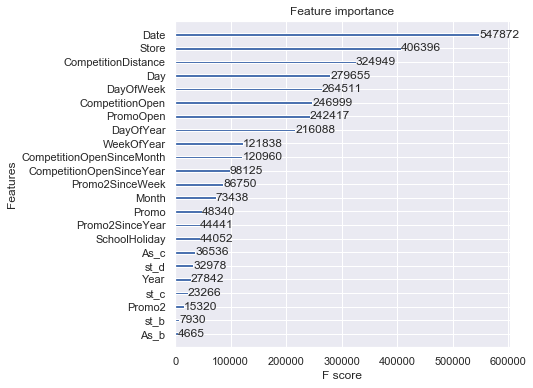

In [70]:
#查看此回归模型下的特征排名
plt.rcParams["figure.figsize"] = [6,6]
xgb.plot_importance(xgb_2)
plt.show()

特征的重要性排名依次为：Date, Store, CompetitionDistance, DayOfWeek,Day，等等。

可见日期和店的差异性还是具有非常差异化的重要性。

除去时间和店的差异化的情况，对营业额起到重要作用的特征有：CompetitionDistance,PromoOpen,CompetitionOpen,Promo2SinceWeek。可见，竞争者的距离和开业情况，以及两种促销都会影响到营业额的变化。


In [71]:
#预测测试集（2015.8.1-2015.9.17）
dtest = xgb.DMatrix(df_test[features])
y_pred = xgb_2.predict(dtest)

In [72]:
#按照kaggle的格式要求生成预测数据集，并存为csv文件
forecasts = pd.DataFrame({'Id': df_test['Id'], 'Sales': (np.exp(y_pred)-1)}) #0.985是一个对rmspe的校正因子 https://www.kaggle.com/c/rossmann-store-sales/discussion/17601
forecasts.to_csv('rossmann_pred.csv', index=False)

In [73]:
#预测提前切分出去的测试集（2015年7月整月）
d_eval = xgb.DMatrix(df_eval[features])
y_eval_pred = xgb_2.predict(d_eval)

In [74]:
#对提前切分出去的2015年7月数据计算rmspe
rmspe_7 = rmspe((np.exp(y_eval_pred)-1)*0.985, df_eval['Sales']) #0.985是一个对rmspe的校正因子 https://www.kaggle.com/c/rossmann-store-sales/discussion/17601
print("用2015年7月的营业额评估的rmspe为：",rmspe_7)    

用2015年7月的营业额评估的rmspe为： 0.123737547305


rmspe_7从之前未删除异常值的得分0.165降到现在的0.132，**又从0.132降到现在的0.124,** 我已经比较满意。接下来很难通过微调xgb的参数来大幅降低rmspe到0.11773（在Kaggle上的此次竞赛，最终吸引了3303名竞赛者提交了结果。其中第330名（10% percentile）的得分为0.11773（即RMSPE）。此为我之间设定的目标基础，即尽量在我的小数据集上跑出接近这样的分数）    

## 可视化预测值

In [75]:
df_forecast = pd.merge(forecasts, df_test, how = 'inner', on = 'Id')
df_eval['Sales_pred'] = np.exp(y_eval_pred)-1

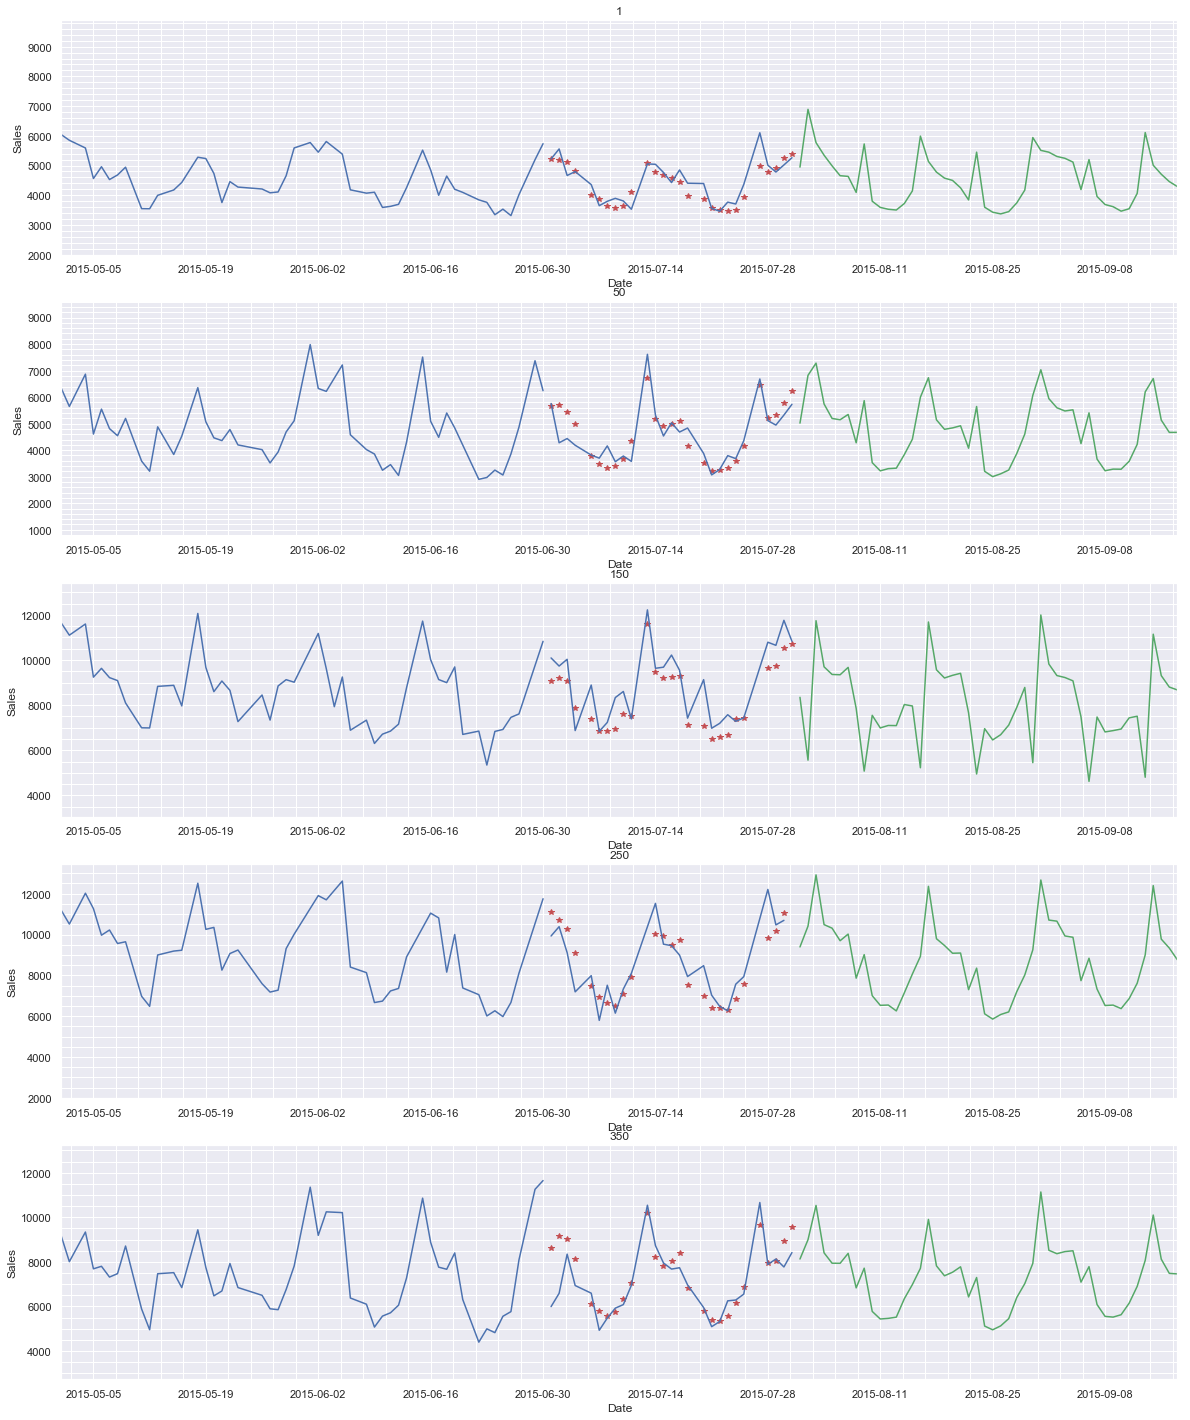

In [76]:
list_stores = [1,50,150,250,350]

plt.rcParams["figure.figsize"] = [20,len(list_stores)*5]

j = 1
for i in list_stores:
        
    X1 = df_train[df_train['Store'] == i]
    y1 = df_train[df_train['Store'] == i]['Sales']
    
    X2 = df_forecast[df_forecast['Store'] == i]
    y2 = df_forecast[df_forecast['Store'] == i]['Sales']
    
    X3 = df_eval[df_eval['Store'] == i]
    y3 = df_eval[df_eval['Store'] == i]['Sales_pred']
    
    X4 = df_eval[df_eval['Store'] == i]
    y4 = df_eval[df_eval['Store'] == i]['Sales']
    
    X1['Date']=pd.to_datetime(X1['Date'])
    X2['Date']=pd.to_datetime(X2['Date'])
    X3['Date']=pd.to_datetime(X3['Date'])
    X4['Date']=pd.to_datetime(X4['Date'])
    
    plt.subplot(len(list_stores),1,j)
    plt.plot(X1['Date'], y1, 'b-')
    plt.plot(X2['Date'], y2, 'g-') #2015.8.1-2015.9.17的预测值
    plt.plot(X3['Date'], y3, 'r*') #2015.7.1-2015.7.31的预测值
    plt.plot(X4['Date'], y4, 'b-') #2015.7.1-2015.7.31的实际值
    plt.xlim('2015-05-01','2015-9-17')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    
    plt.minorticks_on()
    plt.grid(True, which='both')
    plt.title(i)  
    j += 1

以上红点为对2015.7.1-2015.7.31的预测值。蓝色线为零售额的实际值。绿色线为对2015.8.1-2015.9.17的预测值。由上可见，红色点的预测值，呈现出了正确下降和上升的趋势，而且在大部分的单日营业额的预测上，还是有一定的准确度。但是在更细化的预测上，有些点的预测距离实际值还是有偏差。这个需要通过进一步优化模型来改进。

## 结果讨论 & 下一步优化方向

1. 更多的特征工程和选择。
  - 此次竞赛第一名反复强调了，他花了80%左右的时间在进行特征工程，选了上百种特征，跑了大约500个随机模型，最终在相同的模型上跑了十几对不同的特征，才拿到这样的分数。遗憾的是，他并没有明确说最后选定了哪十几个特征值。其他优胜者也基本做了大量的特征选择工作，最终选定了10-20种特征值。
  - 下一步我还需要花更多的时间来进行特征的创建和选取。以上rmspe_7 = 0.13204的得分，很难再通过对xgb的参数进行微调来大幅度降低。必须通过更多的特征探索来优化模型，尤其是在时间序列的探索上和降低各店差异化的特征探索上。从回归的xgb_2的重要性排名上，排名第一名和第二名分别是Date和Store，说明时间序列和店之间存在很大的差异，而特征工程并没有有效地捕捉到有规律的时间特征和店的特征。这些都需要在下一步的特征工程中深入探究。
  - 尝试非监督学习中的PCA和聚类等来对不同的店进行特征归类。

2. 时间序列的分析（TSA）和arima模型探索。正如在开题报告中所说，有多位参赛者提到了TSA和arima模型，甚至有参赛者进行了tsa模型和xgboost的模型的叠加，得分跟xgboost接近。由于TSA-arima是常用的预测带有季节性时间周期的有效线性回归模型，下一步可以考虑加入arima模型来捕捉到更多的时间周期和季节性的变化，优化时间序列相关的特征选择。


3. 删除更多的异常值。本次模型中，我把阈值设定为默认的3，从而分别从训练集和验证集中删除掉仅仅1.6%，1.5%左右的异常值。由于rmspe对异常值比较敏感，我没删除异常值时，跑出的rmspe_7的数值为0.165左右，而在删除掉1.6%左右的异常值之后，rmspe的得分从1.65有效的降低到1.32。但其实全数据集中1.6%的异常值，不是太多。可以考虑降低阈值，从而删除更多的异常值，有望进一步降低rmspe得分值。

## 参考资料

**竞赛资料及讨论相关**

https://www.kaggle.com/c/rossmann-store-sales/discussion/18024

https://www.kaggle.com/abhilashawasthi/xgb-rossmann

https://www.kaggle.com/c/rossmann-store-sales/discussion/17896

https://www.kaggle.com/c/rossmann-store-sales/discussion/17601

https://www.datarobot.com/wiki/training-validation-holdout/

https://www.kaggle.com/benhamner/random-forest-example

http://nbviewer.jupyter.org/github/JohanManders/ROSSMANN-KAGGLE/blob/master/ROSSMANN%20STORE%20SALES%20COMPETITION%20KAGGLE.ipynb

http://mabrek.github.io/blog/kaggle-forecasting/


**数据处理&可视化相关**

https://pandas.pydata.org/pandas-docs/stable/timeseries.html

https://pandas.pydata.org/pandas-docs/stable/visualization.html

https://seaborn.pydata.org/tutorial/relational.html#emphasizing-continuity-with-line-plots

https://seaborn.pydata.org/examples/many_pairwise_correlations.html?highlight=figsize

https://seaborn.pydata.org/tutorial/color_palettes.html?highlight=cmap

**时间系列分析TSA & ARIMA模型相关**

https://github.com/elena-petrova/rossmann_TSA_forecasts/blob/master/Rossmann_Sales.ipynb

https://github.com/aarshayj/Analytics_Vidhya/blob/master/Articles/Time_Series_Analysis/Time_Series_AirPassenger.ipynb

https://otexts.org/fpp2/arima.html

https://www.rdocumentation.org/packages/forecast/versions/7.3/topics/auto.arima

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/


**XGB相关**

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor

https://stats.stackexchange.com/questions/282459/xgboost-vs-python-sklearn-gradient-boosted-trees

https://xgboost.readthedocs.io/en/latest/python/python_intro.html

https://anaconda.org/anaconda/py-xgboost

https://github.com/dmlc/xgboost/tree/master/demo/guide-python

https://www.kaggle.com/c/rossmann-store-sales/discussion/16794


**Outliers相关**

https://docs.oracle.com/cd/E40248_01/epm.1112/cb_statistical/frameset.htm?ch07s02s10s01.html
